### Primera prueba de POD
<p align="justify"> Primero cargamos las librerías que se van a usar</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import linalg
import matplotlib.patches as mpatches
import cmocean

<p align="justify"> Importamos los datos de la simulación de flujo alrededor de un cilindro tomado de <strong> Dynamic Mode Decomposition: data-driven modelling for complex systems </strong> </p>

In [2]:
CYLINDER = scipy.io.loadmat('CYLINDER_ALL.mat', struct_as_record=True)
VORTALL = CYLINDER['VORTALL']

In [31]:
def plotField(Field):
    x = np.arange(0, 449, 1)
    y = np.arange(0, 199, 1)
    mX, mY = np.meshgrid(x, y)

    img = Field.reshape(449,199)


    minmax = 4
    plt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    plt.contourf(mX, mY, img.T, 40, cmap=cmocean.cm.balance, alpha=0.8, vmin=-minmax, vmax=minmax)
    plt.contour(mX, mY, img.T, 30, colors='black', alpha=0.5, vmin=-minmax, vmax=minmax)
    im = plt.imshow(img.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)

    cyl = plt.Circle((49,99), 25, ec="#030303", color='#030303',lw = 5, zorder=200)
    im.axes.add_patch(cyl)


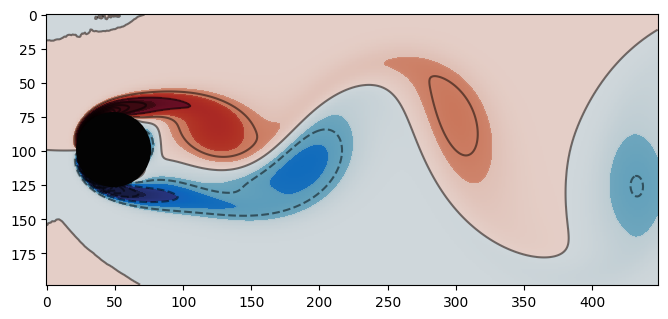

In [32]:
#Se toman snapshot cada 10*delta(t), y el delta(t) = 0.02 para satsifacer CFL
delta_t = 0.02
t_analisis = 10
t_index = int(t_analisis/(10*delta_t))

#Dominio espacial
ny = 449
nx = 199

vortex15 = VORTALL[:,t_index]
plotField(vortex15)


In [39]:
U, S, Vh = scipy.linalg.svd(VORTALL[:,0:150], full_matrices=False)
U.shape, S.shape, Vh.shape

((89351, 150), (150,), (150, 150))

In [9]:
print("Filas de U: ",len(U), "Columns de U: ",len(U[0]))
print("Filas de V transpuesto: ",len(Vh), "Columns de V transpuesto: ",len(Vh[0]))
print("Filas de S: ",len(S))

Filas de U:  89351 Columns de U:  150
Filas de V transpuesto:  150 Columns de V transpuesto:  150
Filas de S:  150


In [17]:
#Revisamos si la operación se hizo correctamente
print(np.allclose(VORTALL[:,0:150], np.dot(U*S, Vh)))
print(np.allclose(VORTALL[:,0:150], np.dot(U, np.reshape(S, (150,1))*Vh)))

True
True


<p align = "justify"> En las siguientes 2 celdas compruebo qué tipo de operación es "<b>*</b>". Para esto, creo que una matriz <b>a</b> de prueba, una matriz diagonal <b>b</b> un vector columna <b>c</b> que contiene la diagonal de <b>b</b></p>

In [41]:
#¿Qué tipo de operación es *?
a = np.array([[1,3,4],[1,2,2],[1,4,1]])
print(a,"\n")

b = np.identity(3)
b[0,0] = b[0,0]*2
b[1,1] = b[1,1]*3
b[2,2] = b[2,2]*4
print(b,"\n")

c = np.array([[2], [3], [4]])
print(c,"\n")

[[1 3 4]
 [1 2 2]
 [1 4 1]] 

[[2. 0. 0.]
 [0. 3. 0.]
 [0. 0. 4.]] 

[[2]
 [3]
 [4]] 



<p align = "justify"> Hago producto punto entre <b>a</b> y <b>b</b> y reviso si eso es igual a la multiplicación puesto por puesto entre <b>a</b> y <b>c</b>. Si $\Sigma$ es un vector columna (ya lo verificamos arriba con S.shape) ¿Por qué al momenot de usarlo en la operación de multiplicación puesto por puesto se opera como si fuera un vector fila (Notar que no hizo falta transponerlo)?</p>

In [43]:
print(np.dot(a,b),"\n")
print(a*c.T,"\n")

[[ 2.  9. 16.]
 [ 2.  6.  8.]
 [ 2. 12.  4.]] 

[[ 2  9 16]
 [ 2  6  8]
 [ 2 12  4]] 



<p align = "justify"> Experimento para revisar los conceptos de column major y row major. Python guarda las matriices agrupando por filas, mientras que matlab guarda las matrices agrupándolas por columnas. Esto es importante entenderlo debido a que influye enormemente en la operación de la función <b>reshape</b>. Si yo quiero obtener la matriz A, a partir de los snapshots que  me dieron en vector b (obtenido usando reshape en Matlab), debo hacer los siguientes pasos:</p>

$$
A =\left(\begin{array}{cc}
1 & 2 & 3 \\
4 & 5 & 6 \\
\end{array}\right)
$$

In [100]:
b = np.array([[1], [4], [2], [5], [3], [6]])
print(b)
c = np.reshape(b, (3, 2))
print(c.T)

[[1]
 [4]
 [2]
 [5]
 [3]
 [6]]
[[1 2 3]
 [4 5 6]]


In [107]:
from jax import grad
import jax.numpy as jnp

<p align = "justify"> Continuamos haciendo </p>

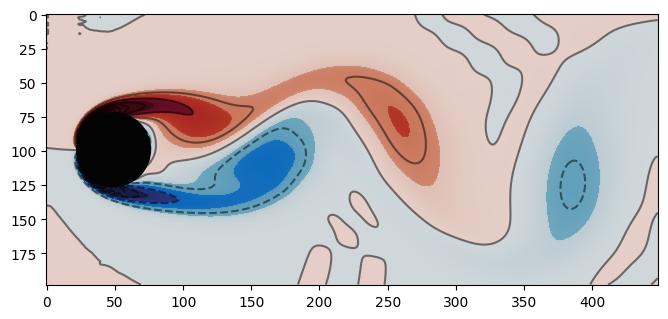

In [45]:
delta_t = 0.02;
t_analisis = 15;
t_index = int(t_analisis/(10*delta_t));

#Construyo las matrices que voy a reducir
alpha = np.reshape(S, (150,1))*Vh


r = 10; #Número de modos a usar
U_red = U[:,:r+1];  #Matriz U reducida
alpha_red = alpha[0:r+1,:]; #Matriz alfa reducida

vortex_red = np.dot(U_red, alpha_red[:,t_index])

plotField(vortex_red)

